In [14]:
import openml
from benchmark_utils import *
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
benchmark_suite = openml.study.get_study('OpenML-CC18','tasks') # obtain the benchmark suite
print(benchmark_suite.tasks)

[3, 6, 11, 12, 14, 15, 16, 18, 22, 23, 28, 29, 31, 32, 37, 43, 45, 49, 53, 219, 2074, 2079, 3021, 3022, 3481, 3549, 3560, 3573, 3902, 3903, 3904, 3913, 3917, 3918, 7592, 9910, 9946, 9952, 9957, 9960, 9964, 9971, 9976, 9977, 9978, 9981, 9985, 10093, 10101, 14952, 14954, 14965, 14969, 14970, 125920, 125922, 146195, 146800, 146817, 146819, 146820, 146821, 146822, 146824, 146825, 167119, 167120, 167121, 167124, 167125, 167140, 167141]


In [130]:
np.random.seed(1)
n_iterations = 2
n_trees = np.arange(20, 80, step=20)

rerfs = ['binnedBaseRerF', 'rerf'] 
sklearns = ['RandomForest', 'ExtraTrees']

bm_rerfs = np.zeros(shape=(len(n_trees), len(rerfs), 4, n_iterations))
bm_sklearns = np.zeros(shape=(len(n_trees), len(sklearns), 4, n_iterations))

for i, n in enumerate(n_trees):
    bm = benchmark(oml_task_id=3, 
                   preprocess=False, 
                   rerfs = rerfs,
                   sklearns = sklearns,
                   num_trees=n,
                   num_cores=8,
                   n_iterations=n_iterations
         )
    
    for j, rerf in enumerate(bm[0]):
        bm_rerfs[i, j] = bm[0][j]
    
    for j, model in enumerate(bm[1]):
        bm_sklearns[i, j] = bm[1][j]

IndexError: index 2 is out of bounds for axis 0 with size 2

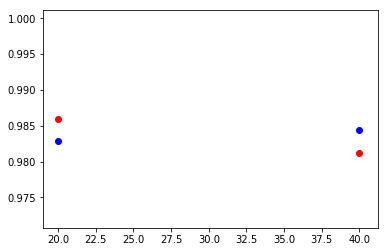

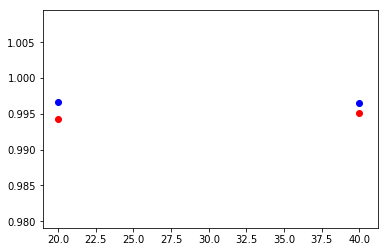

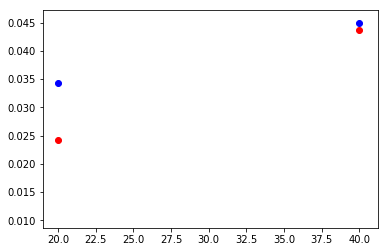

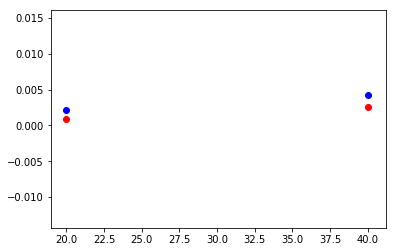

In [133]:
rerf_means = np.mean(bm_rerfs, axis=3)
sklearn_means = np.mean(bm_sklearns, axis=3)

fig, test_acc_ax = plt.subplots(1,1)
fig, train_acc_ax = plt.subplots(1,1)
fig, test_time_ax = plt.subplots(1,1)
fig, train_time_ax = plt.subplots(1,1)

rc = ['r', 'b']
sc = ['g', 'k']

for j, n in enumerate(n_trees):
    for i in range(len(rerfs)):
        test_acc_ax.scatter(n, rerf_means[i][j][0], c = rc[i], label = rerfs[i])
        train_acc_ax.scatter(n, rerf_means[i][j][1], c = rc[i], label = rerfs[i])
        test_time_ax.scatter(n, rerf_means[i][j][2], c = rc[i], label = rerfs[i])
        train_time_ax.scatter(n, rerf_means[i][j][3], c = rc[i], label = rerfs[i])
    
for j, n in enumerate(n_trees):
    for i in range(len(sklearns)):
        test_acc_ax.scatter(n, sklearn_means[i][j][0], c = sc[i], label = sklearns[i])
        train_acc_ax.scatter(n, sklearn_means[i][j][1], c = sc[i], label = sklearns[i])
        test_time_ax.scatter(n, sklearn_means[i][j][2], c = sc[i], label = sklearns[i])
        train_time_ax.scatter(n, sklearn_means[i][j][3], c = sc[i], label = sklearns[i])

test_acc_ax.legend()

In [124]:
test_acc_ax.scatter(n, rerf_means[i][j][0], c = rc[i], label = rerfs[i])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [129]:
rerf_means[0]

array([[0.9859375 , 0.99426287, 0.02332401, 0.00130486],
       [0.978125  , 0.99600139, 0.02682889, 0.00105488]])

In [4]:
def fit_sklearn(X,
                y,
                train_test_splits, 
                forest_type='RandomForest',
                num_trees = None, 
                num_cores = 8, 
                acorn = None
    ):
    # I assume the data has been preprocessed
    if num_trees is None:
        num_trees = 10
    if acorn is None:
        acorn = np.random.randint(100000)
    np.random.seed(acorn)
    
    train_idx = train_test_splits[0]
    test_idx = train_test_splits[1]
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    if forest_type == 'RandomForest':
        model = RandomForestClassifier(n_estimators=num_trees, n_jobs=num_cores)
    elif forest_type == 'ExtraTrees':
        model = ExtraTreesClassifier(n_estimators=num_trees, n_jobs=num_cores)
    else:
        raise ValueError('model %s not implemented'%(forestType))
        
    start = time.time()
    
    model.fit(X_train, y_train)
    
    end_train = time.time()
    
    y_test_hat = model.predict(X_test)
    
    end_predict = time.time()
    test_accuracy = np.sum(y_test_hat == y_test)/len(y_test)
    
    y_train_hat = model.predict(X_train)
    train_accuracy = np.sum(y_train_hat == y_train)/len(y_train)
    
    train_time = end_train - start
    predict_time = end_predict - end_train
    
    return test_accuracy, train_accuracy, train_time, predict_time

In [3]:
def fit_RerF(X,
             y,
             train_test_splits, 
             forest_type = 'binnedBaseRerF', 
             num_trees = None,
             num_cores = 8, 
             acorn = None
    ):
    # I assume data has been preprocessed
    if num_trees is None:
        num_trees = 10
    if acorn is None:
        acorn = np.random.randint(100000)
    np.random.seed(acorn)
    
    train_idx = train_test_splits[0]
    test_idx = train_test_splits[1]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    start = time.time()
    rerf = fastRerF(X_train, y_train, forestType=forest_type, trees=num_trees, numCores=num_cores, seed = acorn)
    end_train = time.time()
    
    y_test_hat = fastPredict(X_test, rerf)
    end_predict = time.time()
    test_accuracy = np.sum(y_test_hat == y_test)/len(y_test)
    
    y_train_hat = fastPredict(X_train, rerf)
    train_accuracy = np.sum(y_train_hat == y_train)/len(y_train)
    
    train_time = end_train - start
    predict_time = end_predict - end_train
    return test_accuracy, train_accuracy, train_time, predict_time

In [5]:
def benchmark(oml_task_id=3, 
              n_iterations = 10,
              preprocess=False,
              train_test_splits = None,
              rerfs=['binnedBaseRerF'], 
              sklearns=['RandomForest'], 
              num_trees = None, 
              num_cores = 8,
              acorn=None
    ):
    if acorn is None:
        acorn = np.random.randint(100000)
    if num_trees is None:
        num_trees = 10
    np.random.seed(acorn)
    
    task = openml.tasks.get_task(oml_task_id)
    X, y = task.get_X_and_y()
    
    if preprocess:
        # TODO
        pass
    
    if train_test_splits is None:
        train_test_splits = task.get_train_test_split_indices()
    else:
        # TODO
        pass
        
    rerf_results = np.zeros(shape=(len(rerfs), 4, n_iterations))
    
    for i, model in enumerate(rerfs):
        for j in range(n_iterations):
            rerf_results[i,:,j]=fit_RerF(X, y, train_test_splits, forest_type=model, num_trees=num_trees, num_cores=num_cores)
        
    sklearn_results = np.zeros(shape=(len(rerfs), 4, n_iterations))
    for i, model in enumerate(sklearns):
        for j in range(n_iterations):
            sklearn_results[i,:,j]=fit_sklearn(X, y, train_test_splits, forest_type=model, num_trees=num_trees, num_cores=num_cores)
    
    return rerf_results, sklearn_results